<a href="https://colab.research.google.com/github/commitit/Reinforcement-Learning/blob/main/AdvancedRL_Latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advanced Reinforcement Learning**

Objectives: Train Advanced Reinforcement Learning (RL with function approximation) methods on the [CArt Pole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) and [Bipedal Walker](https://www.gymlibrary.dev/environments/box2d/bipedal_walker/) OpenAI Gym environments

1. Implement a Linear Value Function approximation method (e.g., Q-Learning with epsilon greedy) and train it on the Cart Pole Environment
2. Improve the DQN agent already implemented by modifying the DQN, or by searching for better parameters
3.   Apply Policy-based/Actor Critic agent to the Bipedal Walker environment







To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

Install needed Python packages

In [74]:
!pip install pygame gym[box2D] numpy

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Using cached swig-4.1.1.post1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for box2d-py
  Running setup.py clean for box2d-py
Failed to build box2d-py
ERROR: Could not build wheels for box2d-py, which is required to install pyproject.toml-based projects


Import basic Python packages

In [75]:
import gym
from gym import spaces
import pygame
import numpy as np

Mount Google Drive for saving results (not needed if running the notebook locally)

In [76]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"         # default location for the drive

drive.mount(ROOT)              # we mount the google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Video Utilities

In [77]:
from pathlib import Path
import base64
from IPython import display as ipythondisplay
from gym.wrappers import RecordVideo

In [78]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [79]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [80]:
def record_video_randpol(env, video_length=0, step_trigger=None, episode_trigger=None,  prefix='', video_folder='videos/'):

  video_env = RecordVideo(env,
                         video_folder=video_folder,
                         episode_trigger=episode_trigger,
                         step_trigger=step_trigger,
                         video_length=video_length,
                         name_prefix=prefix,
                         new_step_api=True
                         )

  observation = video_env.reset()

  step = 0
  ep = 0

  while True:

    if _iterate_condition(step, ep, video_length=video_length, step_trigger=step_trigger, episode_trigger=episode_trigger):

      observation, reward, terminated, _, info = video_env.step(env.action_space.sample())
      step += 1

      if terminated:
        observation = video_env.reset()
        ep += 1
        step = 0

    else:
      break

  video_env.close()

# Utility function for checking stopping condition
def _iterate_condition(step, ep, video_length=0, step_trigger=None, episode_trigger=None):

  if video_length is not 0:
    go = True if step < video_length else False
    return go

  if step_trigger is not None:
    go = step_trigger(step)
    return go

  if episode_trigger is not None:
    go = episode_trigger(ep)
    return go

<>:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-80-f4c1c2aae85b>:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if video_length is not 0:


In [81]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [82]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

# **1) Implement Q-Learning with Linear Function Approximation**

## Inspect `CartPole-v1` environment

Initialize environment with discrete action space (necessary for Q-Learning)

In [83]:
env = gym.make(
    "CartPole-v1",
    new_step_api=True
)

Record and show video

In [84]:
import sys
import os

is_colab = 'google.colab' in sys.modules
root_dir ='drive/MyDrive/CASAdML2024' if is_colab else '.'

In [85]:
video_folder = os.path.join(root_dir, 'Videos')
os.makedirs(video_folder, exist_ok =True)

prefix = 'cart_random'

record_video_randpol(env,
                     video_length=0,
                     episode_trigger=lambda st: st ==1000000,
                     step_trigger=None,
                     prefix=prefix,
                     video_folder=video_folder)

show_videos(video_folder, prefix=prefix)

/usr/local/lib/python3.10/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/CASAdML2024/Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [86]:
print('The action space of the environment is of dimension: {}'.format(env.action_space.n))
print('The observation space of the environment is of dimension {}'.format(env.observation_space.sample().shape))

The action space of the environment is of dimension: 2
The observation space of the environment is of dimension (4,)


In [104]:
import torch
from torch import nn
import torch.nn.functional as F


class LinearQ(nn.Module):

    def __init__(self, action_size, state_size):
        super(LinearQ, self).__init__()

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #initializing the nn.linear layers of the Q Network

        self.m1 = nn.Linear(state_size, 64).to(self.device)  # create first linear layer
        self.m2 = nn.Linear(64, action_size).to(self.device)  # create second linear layer

        # TO DO
        # Initialize a linear layer - check nn.Linear on PyTorch documentation

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        #x = torch.from_numpy(x).float().to(self.device)
        x = torch.tensor(x)
        x = x.to(self.device)
        x = F.relu(self.m1(x))  # applying ReLU activation function to the first layer
        output = self.m2(x)  # output layer without activation

        return output         # TO DO - substitute with the desired output

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
from pyparsing.helpers import Callable
from tqdm import tqdm

def QLearning(env: gym.Env, num_episodes: int, run_episode: Callable, config:dict):
    reward_per_ep = list()
    Q = LinearQ(env.action_space.n, env.observation_space.sample().shape[0])
    loss = nn.MSELoss()
    opt = torch.optim.SGD(Q.parameters(), lr=config['lr']) # is it Q or net
    config['optim'] = opt
    config['loss'] = loss

    for i in tqdm(range(num_episodes)):
        Q, reward = run_episode(env, Q, **config)
        reward_per_ep.append(reward)

    return Q, reward_per_ep


In [108]:
def run_episode_Q(env, Q, lr, discount, optim, loss, epsilon=0.1, render=False, _maxsteps=20, optimal=False):
    observation = env.reset()
    done = False
    nsteps = 0
    reward_per_ep = []

    for x in range(_maxsteps):
        nsteps += 1

        if done:
            break

        if render:
            env.render()

        curr_state = observation

        # training time
        if not optimal:
            # Epsilon-greedy policy
            randnum = np.random.rand(1)
            if randnum < epsilon:
                action = env.action_space.sample()
            else:
                action = torch.argmax(Q(observation)).item()
                # TODO - feed the state into the Linear Q function and get the (best) action according to the Q-Learning formula
                observation, reward, done, _, info = env.step(action)

                reward_per_ep.append(int(reward))
                # TODO - compute the MSE (i.e., the loss function between targets and predictions) according to the Q-Learning formula
                optim.zero_grad()

                with torch.no_grad():
                    next_state = Q(observation)
                    targets = reward + discount * next_state.max()

                estimate = Q(curr_state)[action]
                loss_value = loss(estimate, targets)

                # the targets should be: reward + discount * np.max(Q(next_state))
                # the estimate should be: current estimate of Q(, action)
                # loss = crit(targets, estimate)
                loss_value.backward()
                optim.step()

        # evaluation time
        else:
            action = torch.argmax(Q(observation)).item()
            # TODO - feed the state into the Linear Q function and get the (best) action according to the Q-Learning formula

        observation, reward, done, _, info = env.step(action)
        reward_per_ep.append(int(reward))

    return Q, sum(reward_per_ep)


In [109]:
config = {}
config['lr'] = 0.1
config['discount'] = 0.99
config['epsilon'] = 0.2
num_episodes = 10000

Q_trained, reward_per_ep = QLearning(env,
                                  	 num_episodes,
																		 run_episode=run_episode_Q,
																		 config=config)

  0%|          | 1/10000 [00:00<1:36:04,  1.73it/s]/usr/local/lib/python3.10/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
100%|██████████| 10000/10000 [01:31<00:00, 108.78it/s]


Plot learning curve (i.e., average reward over fixed window)

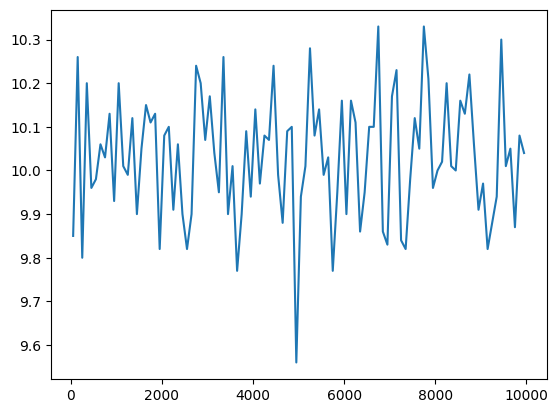

In [110]:
from matplotlib import pyplot as plt

def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

window = 100
t,y = averagewindow(reward_per_ep, d=window)
plt.plot(t, y)

# **2) Improve DQN Agent on `CartPole-v1`**

## Deep Q-Learning Agent

**Replay Memory**: The agent needs a memory buffer to sample experience from

In [111]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):

        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self):
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return (torch.from_numpy(self.obs_buf[idxs]).to(self.device),
                torch.from_numpy(self.acts_buf[idxs]).long().to(self.device),
                torch.from_numpy(self.rews_buf[idxs]).to(self.device),
                torch.from_numpy(self.next_obs_buf[idxs]).to(self.device),
                torch.from_numpy(self.done_buf[idxs]).to(self.device))

    def __len__(self):
        return self.size

**DQN**: The Q network that returns Q-values for state-action pairs

In [112]:
import torch
from torch import nn
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, action_size, input_dim=1):
        super(DQN, self).__init__()

        self.action_size = action_size

        # Network
        self.f1 =  nn.Linear(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.f2 = nn.Linear(32, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.head = nn.Linear(32, self.action_size)

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):

        x = x.to(self.device)

        x = F.relu(self.bn1(self.f1(x)))
        x = F.relu(self.bn2(self.f2(x)))

        return self.head(x)


**Agent**: The Python class featuring the main learning steps for the DQN agent

In [113]:
from math import tau
from torch import optim
import random

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, dqn, memory, lr=1e-4, batch_size=64, update_every=5, gamma=0.99, tau=1e-3, epsilon=0.1, seed=0, render=False, optimal=False):
        """Initialize an Agent object.

        Params
        ======
            dqn (nn.Module): Module implementing the DQN
            memory (object): Replay buffer object
            seed (int): Random seed
        """

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Q-Network
        self.qnetwork_local = dqn.to(self.device)
        self.qnetwork_target = dqn.to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Other params
        self.lr = lr
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon

        self.render = render
        self.optimal = optimal

        # Replay memory
        self.memory = memory
        # Initialize time step (for updating every update_every steps)
        self.t_step = 0

    def episode(self, env, max_steps=1000):

        state = env.reset()
        score = 0

        if self.render:
          env.render()

        for _ in range(max_steps):

            action = self.act(state, self.epsilon)
            a = env.step(action)
            next_state, reward, done, _, info = env.step(action)

            if not(self.optimal):
              self.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break

        return score

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (1 - dones.unsqueeze(1)))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions.unsqueeze(1))

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()

        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.qnetwork_local.action_size))

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


**Main training function**: the function that trains the agent on the environment

In [114]:
from tqdm import tqdm

def DeepQLearning(env: gym.Env, agent: object, num_episodes: int, max_steps=1000, save_model=None):

  reward_per_ep = list()

  for i in tqdm(range(num_episodes)):
    reward = agent.episode(env, max_steps=max_steps)
    reward_per_ep.append(reward)

  if save_model is not None:
    torch.save(agent.qnetwork_local.state_dict(), save_model)

  return reward_per_ep

## Training & Evaluation

Define parameters and initialize modules

In [115]:
# set parameters of the Agent and ReplayBuffer
lr = 1e-4
batch_size = 64
update_every = 5
gamma = 0.99
tau = 0.01
epsilon = 0.1

buffer_size=int(1e+4)
seed=0

# instantiate Q-network
dqn = DQN(action_size=env.action_space.n,
          input_dim=env.observation_space.shape[0])

# instantiate memory buffer
memory = ReplayBuffer(obs_dim=env.observation_space.shape[0],
                      size=buffer_size,
                      batch_size=batch_size)
# instantiate agent
agent = Agent(dqn,
              memory,
              lr=lr,
              batch_size=batch_size,
              update_every=update_every,
              gamma=gamma,
              tau=tau,
              epsilon=epsilon)

# number of episodes and file path to save the model
num_episodes = 10000
model_dir = os.path.join(root_dir, 'Models')
save_model = os.path.join(model_dir, 'ffdqn_{}episodes.pth'.format(num_episodes))
os.makedirs(model_dir, exist_ok =True)

Run training loop

In [ ]:
R = DeepQLearning(env, agent, num_episodes, save_model=save_model)

 63%|██████▎   | 6270/10000 [13:37<09:59,  6.23it/s]

Plot learning curve (i.e., average reward over fixed window)

In [ ]:
from matplotlib import pyplot as plt

def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

window = 10
t,y = averagewindow(R, d=window)
plt.plot(t, y)

In [ ]:
import os

# set parameters to evaluate agent
agent.optimal = True
agent.epsilon = 0.0
vid_episodes = 5
prefix = os.path.basename(save_model).split('.')[0]

# use wrapper to record videos
env_vid = RecordVideo(env,
                      video_folder=video_folder,
                      episode_trigger=lambda ep: (ep < vid_episodes),
                      step_trigger=None,
                      video_length=0,
                      name_prefix=prefix,
                      new_step_api=True
                      )

# use wrapper to record videos
R_test = DeepQLearning(env_vid, agent, vid_episodes)


In [ ]:
show_videos(video_folder, prefix=prefix)

## Improve the current agent

Pick (at least) one of the following tasks:

1.   Look for better hyper-parameters of the algorithm (e.g., learning rate, batch size, epsilon, etc.).
2.   Focus on the DQN architecture. For instance, add regularization techniques (e.g., dropout) in the current feed-forward network. Otherwise, you could embed temporal information into the Q network by using the [Frame Stack](https://www.gymlibrary.dev/api/wrappers/#available-wrappers) wrapper for feeding sequential data and [Recurrent](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)/[Attention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) layers for processing them.



In [ ]:
# TO COMPLETE

# **3) Implement (Deep) RL Algorithm on `BipedalWalker-v3`**

Further documentation for this environment is available [here](https://www.gymlibrary.dev/environments/box2d/bipedal_walker/).

Note: this environment does not provide discrete actions. Therefore, the vanilla DQN algorithm can't be applied without discretizing etc.
Implement a policy/actor-critic approach to deal with continous action spaces.

Hint: You can modify the previously defined `Agent` class to implement the [Deep Deterministic Policy Gradient](https://arxiv.org/pdf/1509.02971.pdf) (DDPG) algorithm (check in particular Algorithm 1 of the paper). Most of the Deep RL algorthms need replay buffers, so the `ReplayBuffer` class can be directly re-used.
Also, many implementations online (e.g., https://spinningup.openai.com/en/latest/_modules/spinup/algos/pytorch/ddpg/ddpg.html)

If the algorithm is too complex, or the training time is too long, stick to a more simple policy-based algorithm like REINFORCE (i.e., Monte Carlo updates of a linear policy). Take advantage of previously defined functions and training loops to speed-up coding and make the relevant and needed changes.
Pseudo-code for REINFORCE in the following picture:
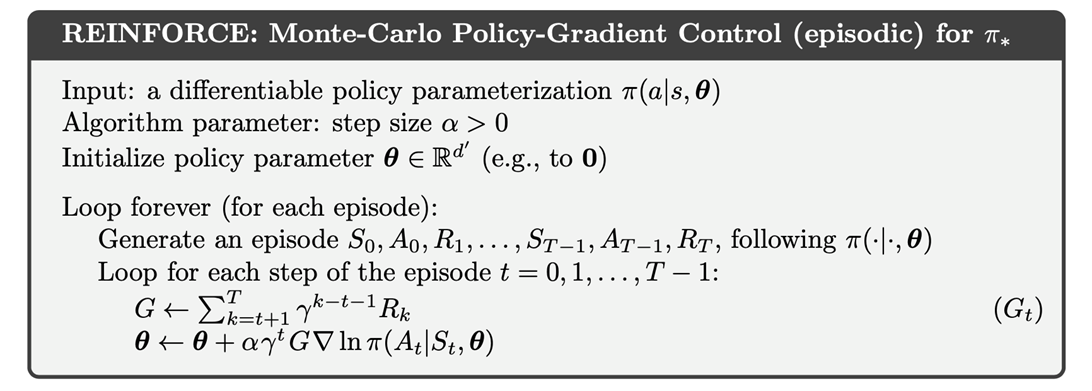

Instantiate `BipedalWalker-v3` environment

In [ ]:
env = gym.make(
    "BipedalWalker-v3",
    new_step_api=True
)

Record and show video

In [ ]:
prefix = 'bipwalk_random'

record_video_randpol(env,
                     video_length=100,
                     episode_trigger=None,
                     step_trigger=None,
                     prefix=prefix,
                     video_folder=video_folder)

show_videos(video_folder, prefix=prefix)

In [ ]:
# TO COMPLETE